In [47]:
%reload_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -a 'Marcos Santana' -d -p fastai,descriptastorus,numpy,pandas,torch,joblib,guacamol,fastinference,rdkit,tqdm -v

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Marcos Santana

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

fastai         : 2.7.9
descriptastorus: 2.3.0.6
numpy          : 1.22.3
pandas         : 1.4.2
torch          : 1.12.0
joblib         : 1.1.0
guacamol       : 0.5.4
fastinference  : 0.0.36
rdkit          : 2022.03.4
tqdm           : 4.62.3



# Dependencies and module

In [48]:
import pandas as pd
import numpy as np

from fastai.text.all import *
from denovo_design.tokenizer import MolTokenizer
from denovo_design.generative_callback import *

from tqdm.notebook import trange, tqdm
from rdkit import rdBase

rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.info')
from rdkit.Chem import MolFromSmiles, MolToSmiles

# Load data

In [49]:
lm_data = pd.read_csv(f'../datasets/processed_data/chembl_30_processed.csv',compression='gzip').sample(n=10)

In [50]:
lm_data.head()

,doc_id,processed_smiles,standard_value,standard_units,standard_type,standard_relation,molregno,canonical_smiles,chembl_id,tid,target_chembl_id,organism,l1,l2,l3,inchi,Stereo,duplicate
387956,15315.0,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1,10.3,nM,Ki,=,250328.0,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1,CHEMBL1279,105.0,CHEMBL1983,Homo sapiens,Membrane receptor,Family A G protein-coupled receptor,Small molecule receptor (family A GPCR),XPSQPHWEGNHMSK-SECBINFHSA-N,2_R,1.0
385524,82238.0,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C(F)(F)F,9.8,nM,IC50,=,704201.0,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2ccncc2[nH]1)C(F)(F)F,CHEMBL1254734,25.0,CHEMBL2034,Homo sapiens,Transcription factor,Nuclear receptor,Nuclear hormone receptor subfamily 3,DJRNAIGSFHOUFL-UHFFFAOYSA-N,13_?,1.0
149892,57951.0,N=C(N)C1CCC1,380.0,nM,IC50,=,1149735.0,N=C(N)C1CCC1,CHEMBL1783072,12425.0,CHEMBL4481,Homo sapiens,Enzyme,NaN,NaN,YRTJYDRUQDCJKA-UHFFFAOYSA-N,NaN,0.0
91250,38122.0,CNC(=O)c1cn2ncnc(Nc3cc(C(=O)NOC)ccc3C)c2c1C,23.0,nM,IC50,=,419083.0,CNC(=O)c1cn2ncnc(Nc3cc(C(=O)NOC)ccc3C)c2c1C,CHEMBL251930,10188.0,CHEMBL260,Homo sapiens,Enzyme,Kinase,Protein Kinase,GLQHXGSWFVZXAN-UHFFFAOYSA-N,NaN,0.0
564790,102904.0,O=C(Nc1cc(Cl)ccc1OC1CCC(O)CC1)c1cnn2cc(O)cnc12,93.0,nM,IC50,=,2148797.0,O=C(Nc1cc(Cl)ccc1OC1CCC(O)CC1)c1cnn2cc(O)cnc12,CHEMBL3939426,19631.0,CHEMBL3778,Homo sapiens,Enzyme,Kinase,Protein Kinase,WRDPDAIOMMMLNR-UHFFFAOYSA-N,11_?|14_?,1.0


In [51]:
MODELS = Path('models')
FT = Path(f'{MODELS}/finetuning')
ENCODER = Path(f'{MODELS}/encoder')
FT.mkdir(exist_ok=True, parents=True)
ENCODER.mkdir(exist_ok=True, parents=True)
FT,ENCODER

(Path('models/finetuning'), Path('models/encoder'))

# Dataloader

In [52]:
config=awd_lstm_lm_config.copy()

In [53]:
splitter = RandomSplitter(0.10)
spec_toks = [BOS, PAD]
text_col = 'processed_smiles'
tfms = [attrgetter(text_col),
        Tokenizer.from_df(text_cols=text_col,tok=MolTokenizer(),rules=[],tok_text_col=text_col),
        Numericalize(min_freq = 1, special_toks=spec_toks)]
dst = Datasets(lm_data, tfms=[tfms], splits = splitter(lm_data), dl_type=LMDataLoader)

In [54]:
dls = dst.dataloaders(bs=128,seq_len=30)

In [55]:
dls.vocab = [x for x in dls.vocab if x != 'xxfake']

In [56]:
len(dls.train), len(dls.valid)

(1, 0)

In [57]:
dls.show_batch()

,text,text_
0,xxbos O =,O = C
1,C ( N,( N /
2,/ N =,N = C
3,C / c,/ c 1
4,1 c c,c c c
5,c c (,c ( O
6,O C c,C c 2
7,2 c c,c c c
8,c c c,c c 2


In [58]:
FT

Path('models/finetuning')

In [59]:
torch.save(dls, ENCODER/f'encoder_dataloader.pkl')

# Finetuning generative model

In [39]:
#dls = torch.load(FT/f'dls.pkl')

In [40]:
vocab_path = ENCODER/'vocab.pkl'
#pretrained_path = ENCODER/'models/fit6.pth'
#pretrained_path,vocab_path

In [41]:
sampler_cb = GenerativeCallback(reference_mols = lm_data.processed_smiles.unique().tolist(),temperature=1.0,max_mols=200,max_size=100)
lm_data.shape[0]

676798

In [42]:
validity_score = ValueMetric(sampler_cb._validity_score, 'Validity')
novelty_score = ValueMetric(sampler_cb._novelty_score, 'Novelty')
uniqueness_score = ValueMetric(sampler_cb._uniqueness_score, 'Uniqueness')

In [43]:
cbs = [sampler_cb, CSVLogger(append=True)]
metrics = [validity_score, novelty_score, uniqueness_score]

In [44]:
learn = language_model_learner(dls, AWD_LSTM,pretrained=False,path=ENCODER,metrics=metrics,drop_mult=0.5)
learn.unfreeze()

SuggestedLRs(valley=0.00019648678426165134)

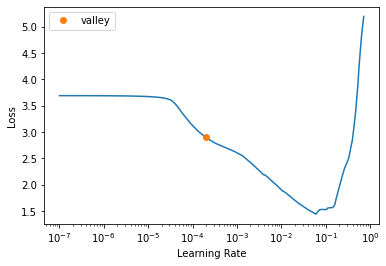

In [20]:
learn.lr_find(num_it=600)

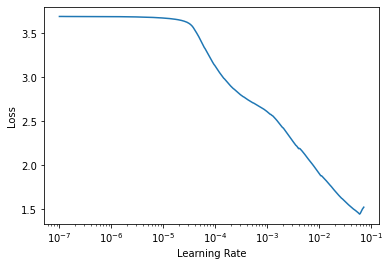

In [21]:
learn.recorder.plot_lr_find(skip_end=80)

In [45]:
lrs=5e-3
lr = slice(lrs/2.6**4, lrs)

In [46]:
learn.fit_one_cycle(3, lr, cbs=cbs)

epoch,train_loss,valid_loss,Validity,Novelty,Uniqueness,time



KeyboardInterrupt



In [ ]:
learn.save('fit1');

In [ ]:
learn.fit_one_cycle(5, lr, cbs=cbs)

In [ ]:
learn.save('fit');

In [ ]:
learn.load('fit');
#learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, lr, cbs=cbs)
learn.save('fit');

In [ ]:
7777

In [ ]:
888

In [ ]:
learn.save_encoder('encoder')

In [ ]:
learn.export()

In [ ]:
8

# Generative validation

## 